In [2]:
import numpy as np
import scipy.stats as scs
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib inline
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'

In [178]:
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, ExtraTreesClassifier
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelBinarizer, StandardScaler
from sklearn.base import TransformerMixin, BaseEstimator
from sklearn.metrics import precision_recall_fscore_support, roc_auc_score, precision_recall_curve, average_precision_score
from sklearn.externals import joblib
from sklearn.base import clone

In [39]:
ls

data_exp.ipynb*                    __init__.py*         thresh_losses.json*
equipment_failure_notebook.ipynb*  new_explore.ipynb*   Untitled.ipynb*
frag_tools.py*                     profit_curve.ipynb*
initial_data_cleaning.ipynb*       __pycache__/


In [45]:
from frag_tools import (DropColumns,
                        AddressLatLong,
                        CurrentMakeDummies,
                        Binarize,
                        ChangeTypes,
                        custom_zip_cleaning)
from various_tools import (roc,
                           plot_roc,
                           cross_val_metrics,
                           make_metric_df)

In [5]:
df = pd.read_csv('/mnt/c/Users/kurtrm/Downloads/Predictive_Maintenance_Transformer_Overload_PA.csv', sep=';')

In [7]:
pipe = make_pipeline(CurrentMakeDummies(['Manufacturer',
                                         'Repairs',
                                         'Overloads',
                                         'AssetType']),
                     ChangeTypes(['Age', 'AssetZip'],
                                 [lambda x: float(x.replace(',', '.')),
                                  custom_zip_cleaning]),
                     Binarize(['VegMgmt',
                               'PMLate',
                               'WaterExposure',
                               'MultipleConnects',
                               'Storm']),
                     AddressLatLong(),
                     DropColumns(['AssetCity',
                                  'AssetId',
                                  'AvgRepairCost',
                                  'AssetState',
                                  'MilesFromOcean',
                                  'AssetLocation',
                                  'locationID',
                                  'Latitude1',
                                  'Longitude1',
                                  'AssetZip']))
transformed = pipe.fit_transform(df)

In [8]:
transformed.head()

,VegMgmt,PMLate,WaterExposure,MultipleConnects,Storm,Age,Latitude,Longitude,Status,Manufacturer_GE,...,Repairs_Rebuild+3,Overloads_100-120%,Overloads_120-150%,Overloads_Above 150%,Overloads_Below 100%,AssetType_1-Phase Pole Transformer,AssetType_3-Phase Transformer,AssetType_DF-series Transformer,AssetType_Padmount Transformer,AssetType_Voltage Transformer
0,1,0,0,1,0,70.3,33.516805,-84.258478,1,0,...,1,0,0,0,1,1,0,0,0,0
1,1,0,0,0,0,70.3,33.959887,-84.435503,1,0,...,0,0,0,0,1,1,0,0,0,0
2,1,0,0,0,0,70.3,33.932735,-84.259163,0,0,...,0,0,0,1,0,1,0,0,0,0
3,1,0,0,1,0,70.3,33.555964,-84.257573,0,0,...,0,0,0,1,0,1,0,0,0,0
4,1,0,0,0,0,70.3,33.478919,-84.354102,0,0,...,0,0,0,1,0,1,0,0,0,0


In [13]:
# For later use
lat_longs_status = transformed[['Latitude', 'Longitude', 'Status']]

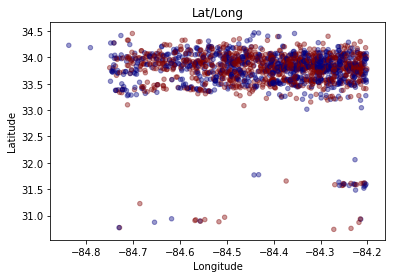

In [18]:
lat_longs_status.plot(kind='scatter', x='Longitude', y='Latitude', alpha=.4,
                      c='Status', cmap=plt.get_cmap("jet"), title='Lat/Long',
                      colorbar=False)

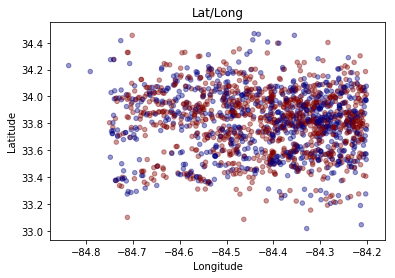

In [20]:
lat_longs_status[lat_longs_status['Latitude'] > 33].plot(kind='scatter', x='Longitude', y='Latitude', alpha=.4,
                      c='Status', cmap=plt.get_cmap("jet"), title='Lat/Long',
                      colorbar=False)

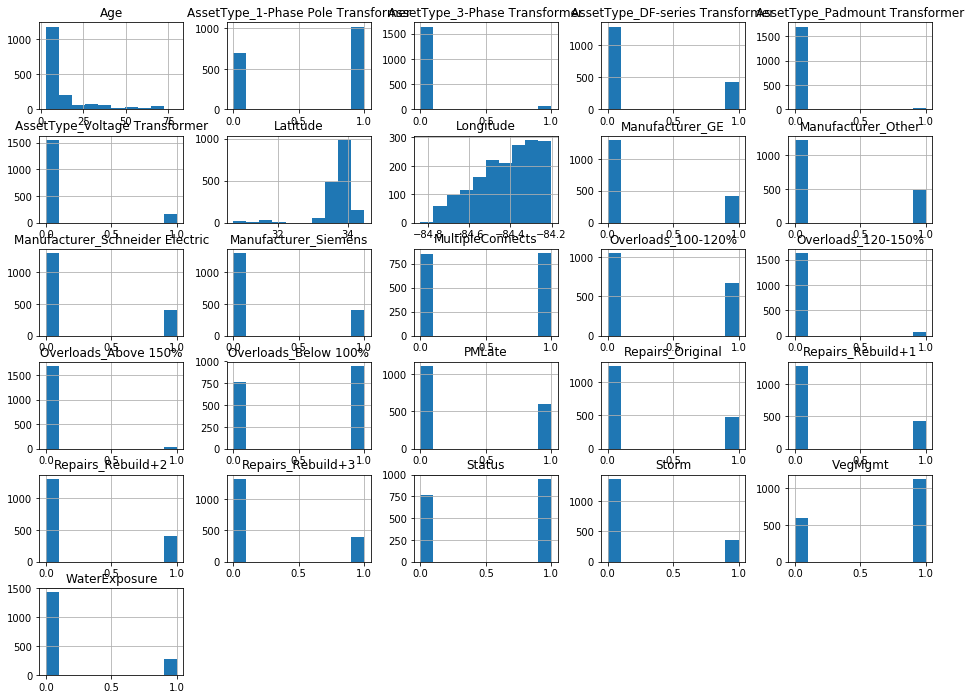

In [24]:
transformed.hist(figsize=(16, 12));

In [57]:
train, test = train_test_split(transformed.drop(['Latitude', 'Longitude'], axis=1), test_size=.2)
X_train, X_test, y_train, y_test = train_test_split(train.drop('Status', axis=1).values,
                                                    train['Status'].values, test_size=.2)

In [58]:
log_reg = LogisticRegression()
rfc = RandomForestClassifier(50)
gbc = GradientBoostingClassifier(learning_rate=.005, subsample=.5, n_estimators=250)
log_reg.fit(X_train, y_train)
rfc.fit(X_train, y_train)
gbc.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=50, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.005, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=250,
              presort='auto', random_state=None, subsample=0.5, verbose=0,
              warm_start=False)

In [59]:
metrics = ['average_precision', 'f1', 'roc_auc', 'neg_log_loss', 'recall']
make_metric_df([log_reg, rfc, gbc], X_test, y_test, metrics)

,GradientBoostingClassifier,LogisticRegression,RandomForestClassifier
average_precision,1.00000,1.00000,1.000000
f1,1.00000,1.00000,1.000000
neg_log_loss,-0.15425,-0.04028,-0.040725
recall,1.00000,1.00000,1.000000
roc_auc,1.00000,1.00000,1.000000


In [62]:
X_train.shape, X_test.shape

((1097, 23), (275, 23))

In [69]:
rfc.feature_importances_.shape

(23,)

In [80]:
rfc_features = pd.DataFrame(rfc.feature_importances_,
                        index=train.drop('Status', axis=1).columns,
                        columns=['Importance'])

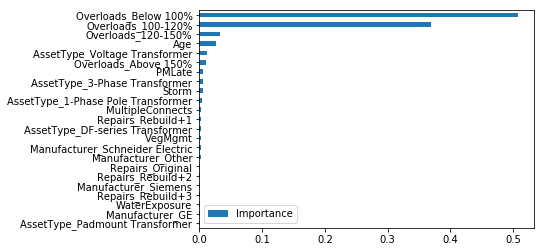

In [82]:
rfc_features.sort_values(by='Importance', ascending=True).plot(kind='barh')

In [83]:
gbc_features = pd.DataFrame(gbc.feature_importances_,
                            index=train.drop('Status', axis=1).columns,
                            columns=['Importance'])

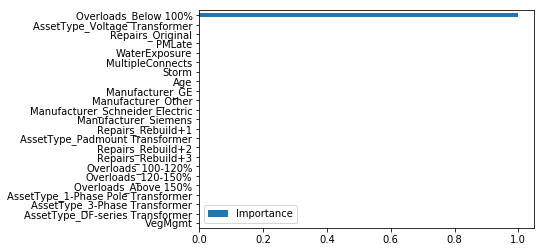

In [84]:
gbc_features.sort_values(by='Importance', ascending=True).plot(kind='barh')

In [88]:
logreg_features = pd.DataFrame(log_reg.coef_.flatten(),
                               index=train.drop('Status', axis=1).columns,
                               columns=['Importance'])

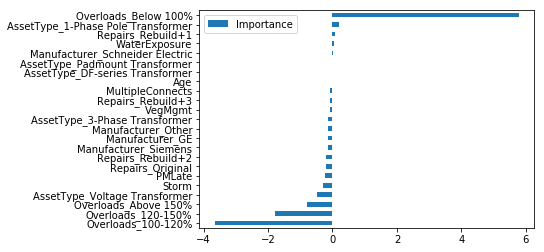

In [89]:
logreg_features.sort_values(by='Importance', ascending=True).plot(kind='barh')

In [109]:
transformed[['Overloads_Below 100%', 'Status']].sum()

Overloads_Below 100%    950
Status                  950
dtype: int64

### Data Leakage in "Overloads_Below 100%"
So...if a transformer has ever been overloaded, it is a "problem transformer."
From [this](https://www.hammondpowersolutions.com/faq/what-is-the-effect-of-overload/) website:
> _Overload is when a transformer is subjected to voltages and/or currents that exceed its design specifications. During overloading conditions, excess heat will cause the insulation system to break down, resulting in decreased life expectancy of the transformer._

This column correlates perfectly with Y, so if we wanted to determine which transformers to service beyond this one, we'll have to remake the models on all other columns.

But there may still be data leakage in the other 'overload' columns, so I should probably drop those as well.

In [98]:
train, test = train_test_split(transformed.drop(['Latitude', 'Longitude', 'Overloads_Below 100%',
                                                 'Overloads_100-120%', 'Overloads_120-150%', 'Overloads_Above 150%'], axis=1), test_size=.2)
X_train, X_test, y_train, y_test = train_test_split(train.drop('Status', axis=1).values,
                                                    train['Status'].values, test_size=.2)

In [99]:
log_reg = LogisticRegression()
rfc = RandomForestClassifier(50)
gbc = GradientBoostingClassifier(learning_rate=.005, subsample=.5, n_estimators=250)
log_reg.fit(X_train, y_train)
rfc.fit(X_train, y_train)
gbc.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=50, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.005, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=250,
              presort='auto', random_state=None, subsample=0.5, verbose=0,
              warm_start=False)

In [100]:
metrics = ['average_precision', 'f1', 'roc_auc', 'neg_log_loss', 'recall']
make_metric_df([log_reg, rfc, gbc], X_test, y_test, metrics)

,GradientBoostingClassifier,LogisticRegression,RandomForestClassifier
average_precision,0.812713,0.730931,0.742275
f1,0.706299,0.670598,0.611601
neg_log_loss,-0.610839,-0.664505,-0.646322
recall,0.771264,0.744138,0.609195
roc_auc,0.760058,0.651522,0.658041


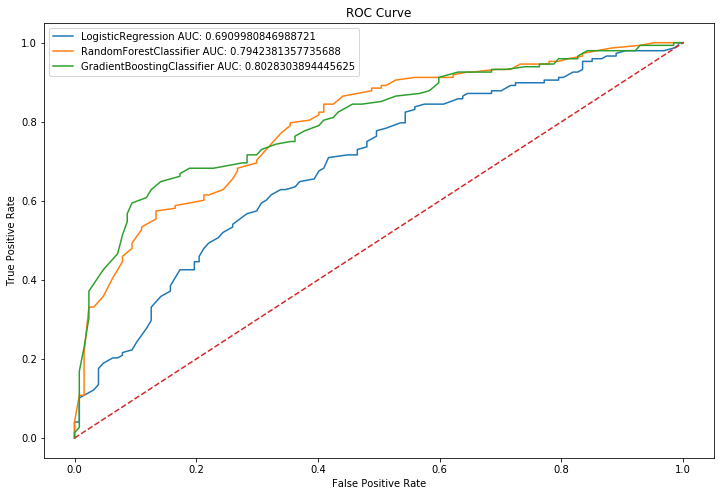

In [106]:
fig, ax = plt.subplots(figsize=(12, 8))
legend = []
for model in [log_reg, rfc, gbc]:
    plot_roc(model, X_test, y_test, ax)
    auc_score = roc_auc_score(y_test, model.predict_proba(X_test)[:, 1])
    legend_data = '{} AUC: {}'.format(model.__class__.__name__, auc_score)
    legend.append(legend_data)
ax.legend(legend)
dashed_line = np.linspace(0, 1, 100)
ax.plot(dashed_line, dashed_line, '--');

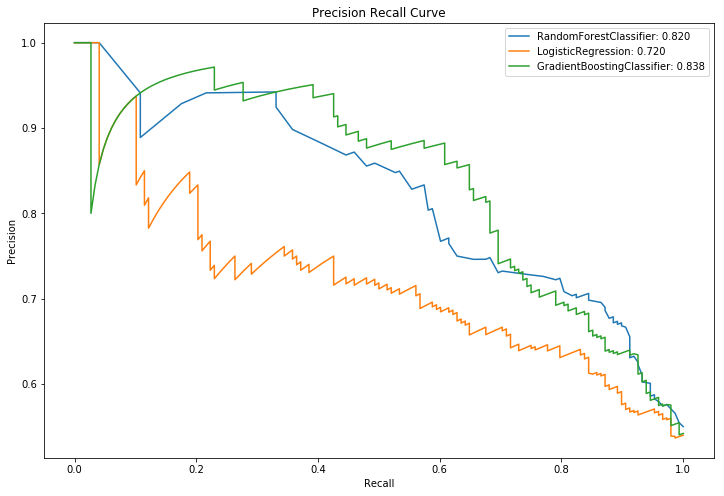

In [107]:
fig, ax = plt.subplots(figsize=(12, 8))
for mod in [rfc, log_reg, gbc]:
    precision, recall, threshold = precision_recall_curve(y_test, mod.predict_proba(X_test)[:, 1])
    avg_prec = average_precision_score(y_test, mod.predict_proba(X_test)[:, 1])
    ax.plot(recall, precision, label=f'{mod.__class__.__name__}: {avg_prec:.3f}')
ax.set_ylabel('Precision')
ax.set_xlabel('Recall')
ax.set_title('Precision Recall Curve')
ax.legend();

In [110]:
rfc_features = pd.DataFrame(rfc.feature_importances_,
                        index=train.drop('Status', axis=1).columns,
                        columns=['Importance'])

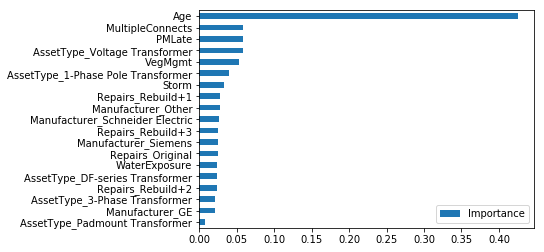

In [111]:
rfc_features.sort_values(by='Importance', ascending=True).plot(kind='barh')

In [112]:
gbc_features = pd.DataFrame(gbc.feature_importances_,
                            index=train.drop('Status', axis=1).columns,
                            columns=['Importance'])

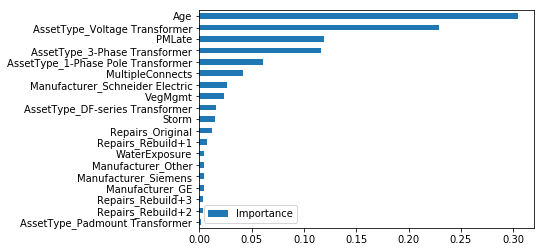

In [113]:
gbc_features.sort_values(by='Importance', ascending=True).plot(kind='barh')

In [114]:
logreg_features = pd.DataFrame(log_reg.coef_.flatten(),
                               index=train.drop('Status', axis=1).columns,
                               columns=['Importance'])

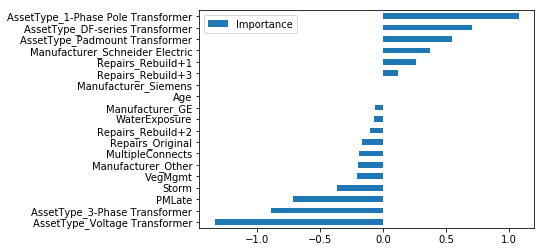

In [115]:
logreg_features.sort_values(by='Importance', ascending=True).plot(kind='barh')

### Initial Assessment
Age is a continuous feature, so it shows up much stronger in the forest models. Made some shitty models, next I'll do some cross validation.

In [159]:
logreg_params = {'penalty': ['l1', 'l2'],
                 'C': [1.0, 10.0, 100.0, 1000.0]}
sgd_params = {'loss': ['log'],
              'penalty': ['elasticnet'],
              'alpha': [.0001, .0005, .001, .005],
              'l1_ratio': [.15, .3, .45, .6, .75],
              'n_jobs': [-1]}
rfc_params = {'n_estimators': [50],
              'criterion': ['gini', 'entropy'],
              'max_features': ['sqrt', 'log2'],
              'min_samples_split': [2, 3, 5],
              'oob_score': [False, True],
              'n_jobs': [-1]}
ext_params_1 = {'n_estimators': [50],
              'criterion': ['gini', 'entropy'],
              'max_features': ['sqrt', 'log2'],
              'min_samples_split': [2, 3, 5],
              'bootstrap': [False],
              'oob_score': [False],
              'n_jobs': [-1]}
ext_params_2 = {'n_estimators': [50],
              'criterion': ['gini', 'entropy'],
              'max_features': ['sqrt', 'log2'],
              'min_samples_split': [2, 3, 5],
              'bootstrap': [True],
              'oob_score': [True],
              'n_jobs': [-1]}
gbc_params = {'n_estimators': [500],
              'learning_rate': [.005, .0001, .0005, .00001],
              'max_depth': [2, 3, 5],
              'min_samples_split': [2, 3, 5],
              'max_features': ['sqrt', 'log2']}

In [163]:
def grid_search_models(models: list, param_dicts: list, X: np.ndarray, y: np.ndarray) -> list:
    """
    Return a list of grid search objects.
    models should contain a list of model class references.
    models and param_dicts will be zipped, so ensure they
    are ordered with each other.
    """
    grid_searched_models = []
    for model, params in zip(models, param_dicts):
        search = GridSearchCV(model(),
                              params, cv=10, refit=True, verbose=True)
        search.fit(X_train, y_train)
        grid_searched_models.append(search)
    
    return grid_searched_models

In [164]:
model_reflist = [LogisticRegression,
                 SGDClassifier,
                 RandomForestClassifier,
                 ExtraTreesClassifier,
                 ExtraTreesClassifier,
                 GradientBoostingClassifier]
params_list = [logreg_params, sgd_params, rfc_params, ext_params_1, ext_params_2, gbc_params]
scores = ['average_precision', 'f1', 'roc_auc', 'neg_log_loss', 'recall']
models = grid_search_models(model_reflist, params_list, X_train, y_train)

Fitting 10 folds for each of 8 candidates, totalling 80 fits


[Parallel(n_jobs=1)]: Done  80 out of  80 | elapsed:    0.5s finished
/home/kurtrm/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)
/home/kurtrm/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and defa

Fitting 10 folds for each of 20 candidates, totalling 200 fits


/home/kurtrm/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)
/home/kurtrm/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)
/home/kurtrm/anaco

/home/kurtrm/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)
/home/kurtrm/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)
/home/kurtrm/anaco

/home/kurtrm/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)
/home/kurtrm/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)
/home/kurtrm/anaco

Fitting 10 folds for each of 24 candidates, totalling 240 fits


[Parallel(n_jobs=1)]: Done 240 out of 240 | elapsed:  1.5min finished


Fitting 10 folds for each of 12 candidates, totalling 120 fits


[Parallel(n_jobs=1)]: Done 120 out of 120 | elapsed:   44.9s finished


Fitting 10 folds for each of 12 candidates, totalling 120 fits


[Parallel(n_jobs=1)]: Done 120 out of 120 | elapsed:   47.2s finished


Fitting 10 folds for each of 72 candidates, totalling 720 fits


[Parallel(n_jobs=1)]: Done 720 out of 720 | elapsed:  6.4min finished


In [149]:
%%time
time_this = [3+10000 for _ in range(10000)]

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 418 µs


In [165]:
joblib.dump(models, 'model_list.pkl')

['model_list.pkl']

In [166]:
model_list = joblib.load('model_list.pkl')

In [172]:
model_list[0].best_params_

{'C': 10.0, 'penalty': 'l2'}

In [179]:
besties = [clone(mod.best_estimator_) for mod in model_list]

In [181]:
besties[0].

LogisticRegression(C=10.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)